# Implementation for Denoising Diffusion Probabilistic Models

### Paper Link: https://arxiv.org/pdf/2006.11239

In [ ]:
# Install required packages
!pip install -q tqdm pyyaml
!pip install -q tqdm pyyaml imageio

In [ ]:
# Import necessary libraries
import os
import math
import yaml
import glob
import torch
import random
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

In [ ]:
# =========================================
# Configuration
# =========================================
config = {
    'dataset': {
        'im_size': 28,            # Image size (28 for MNIST, 32 for CIFAR-10)
        'im_channels': 1,         # Number of channels (1 for MNIST, 3 for CIFAR-10)
    },
    'diffusion': {
        'num_timesteps': 1000,    # Total number of diffusion steps
        'beta_start': 0.0001,     # Initial noise level (β₁)
        'beta_end': 0.02,         # Final noise level (βₜ)
    },
    'model': {
        'down_channels': [32, 64, 128, 256],  # Feature channels at each downsampling level
        'mid_channels': [256, 256, 128],      # Channels in the middle block
        'down_sample': [True, True, False],   # Whether to downsample at each level
        'time_emb_dim': 128,                  # Dimension of time embeddings
        'num_heads': 4,                       # Number of attention heads
        'num_down_layers': 2,                 # Number of residual blocks per level (downsampling)
        'num_mid_layers': 2,                  # Number of residual blocks in middle
        'num_up_layers': 2,                   # Number of residual blocks per level (upsampling)
    },
    'train': {
        'batch_size': 128,         # Batch size for training
        'epochs': 15,              # Number of training epochs
        'lr': 1e-4,                # Learning rate
        'num_samples': 64,         # Number of samples to generate during sampling
        'save_path': '/kaggle/working/ddpm_ckpt.pth'  # Checkpoint save path
    }
}

Using device: cuda


Epoch 1: 100%|██████████| 469/469 [03:37<00:00,  2.16it/s]


Epoch 1 | Loss: 0.1105


Epoch 2: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 2 | Loss: 0.0404


Epoch 3: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 3 | Loss: 0.0335


Epoch 4: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 4 | Loss: 0.0306


Epoch 5: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 5 | Loss: 0.0290


Epoch 6: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 6 | Loss: 0.0278


Epoch 7: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 7 | Loss: 0.0269


Epoch 8: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 8 | Loss: 0.0260


Epoch 9: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 9 | Loss: 0.0255


Epoch 10: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 10 | Loss: 0.0254


Epoch 11: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 11 | Loss: 0.0250


Epoch 12: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 12 | Loss: 0.0245


Epoch 13: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 13 | Loss: 0.0246


Epoch 14: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 14 | Loss: 0.0240


Epoch 15: 100%|██████████| 469/469 [03:38<00:00,  2.15it/s]


Epoch 15 | Loss: 0.0241


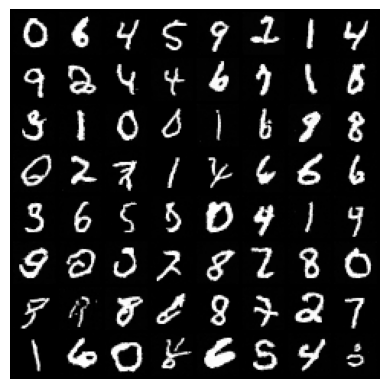

In [ ]:
# Define transformations:
# 1. Convert to tensor
# 2. Normalize to [-1, 1] range (important for diffusion models)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1) # Normalize to [-1,1]
])

# Load MNIST dataset
dataset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

# Create data loader for batched training
loader = DataLoader(dataset, batch_size=config['train']['batch_size'], shuffle=True)

# ==============================================================
# Noise Scheduler: Controls how much noise to add at each step
# ==============================================================
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def add_noise(self, x0, noise, t):
        sqrt_alpha = self.sqrt_alpha_cumprod.to(x0.device)[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod.to(x0.device)[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x0 + sqrt_one_minus_alpha * noise

    def sample_prev(self, xt, noise_pred, t):
        beta = self.betas.to(xt.device)[t].view(-1, 1, 1, 1)
        sqrt_alpha = torch.sqrt(self.alphas.to(xt.device)[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod.to(xt.device)[t].view(-1, 1, 1, 1)

        mean = (xt - beta * noise_pred / sqrt_one_minus_alpha) / sqrt_alpha
        if (t == 0).all():
            return mean
        noise = torch.randn_like(xt)
        return mean + torch.sqrt(beta) * noise


# =============================================================================================
#  U-Net Building Blocks: Neural network architecture for noise prediction
# =============================================================================================
# Encodes the timestep into a vector using sinusoidal embeddings
def get_time_embedding(timesteps, embedding_dim):
    assert embedding_dim % 2 == 0
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=1)
    return emb

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        h += self.time_emb_proj(t_emb)[:, :, None, None]
        h = F.silu(self.norm2(h))
        h = self.conv2(h)
        return h + self.residual_conv(x)

# Adds spatial attention to allow the model to focus on specific image regions
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads):
        super().__init__()
        self.groupnorm = nn.GroupNorm(8, channels)
        self.attn = nn.MultiheadAttention(channels, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.groupnorm(x)
        x_flat = x_norm.view(B, C, H * W).permute(0, 2, 1) # B, HW, C
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        attn_out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return x + attn_out

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, down_sample, num_layers, num_heads):
        super().__init__()
        self.blocks = nn.ModuleList([
            ResBlock(in_channels if i==0 else out_channels, out_channels, time_emb_dim) for i in range(num_layers)
        ])
        self.attn = AttentionBlock(out_channels, num_heads)
        self.down = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if down_sample else nn.Identity()

    def forward(self, x, t_emb):
        for block in self.blocks:
            x = block(x, t_emb)
        x = self.attn(x)
        return self.down(x)

class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_layers, num_heads):
        super().__init__()
        self.blocks = nn.ModuleList([
            ResBlock(in_channels if i==0 else out_channels, out_channels, time_emb_dim) for i in range(num_layers+1)
        ])
        self.attn = AttentionBlock(out_channels, num_heads)

    def forward(self, x, t_emb):
        for block in self.blocks:
            x = block(x, t_emb)
            x = self.attn(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim, up_sample=True, num_layers=1, num_heads=4):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1) if up_sample else nn.Identity()
        total_in_channels = in_channels + skip_channels

        self.blocks = nn.ModuleList([
            ResBlock(total_in_channels if i==0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_layers)
        ])
        self.attn = AttentionBlock(out_channels, num_heads)

    def forward(self, x, skip, t_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        for block in self.blocks:
            x = block(x, t_emb)
        return self.attn(x)


class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.init_conv = nn.Conv2d(config['dataset']['im_channels'], cfg['down_channels'][0], 3, padding=1)
        self.downs = nn.ModuleList([
            DownBlock(cfg['down_channels'][i], cfg['down_channels'][i+1], cfg['time_emb_dim'], cfg['down_sample'][i],
                      cfg['num_down_layers'], cfg['num_heads']) for i in range(len(cfg['down_sample']))
        ])
        self.mid = MidBlock(cfg['mid_channels'][0], cfg['mid_channels'][1], cfg['time_emb_dim'],
                            cfg['num_mid_layers'], cfg['num_heads'])
        self.ups = nn.ModuleList([
            UpBlock(
                in_channels=cfg['down_channels'][i+1],
                skip_channels=cfg['down_channels'][i],
                out_channels=cfg['down_channels'][i],
                time_emb_dim=cfg['time_emb_dim'],
                up_sample=cfg['down_sample'][i],
                num_layers=cfg['num_up_layers'],
                num_heads=cfg['num_heads']
            )
            for i in reversed(range(len(cfg['down_sample'])))
        ])

        self.final_norm = nn.GroupNorm(8, cfg['down_channels'][0])
        self.final_conv = nn.Conv2d(cfg['down_channels'][0], config['dataset']['im_channels'], 3, padding=1)
        self.time_proj = nn.Sequential(
            nn.Linear(cfg['time_emb_dim'], cfg['time_emb_dim']),
            nn.SiLU(),
            nn.Linear(cfg['time_emb_dim'], cfg['time_emb_dim'])
        )

    def forward(self, x, t):
        t_emb = get_time_embedding(t, config['model']['time_emb_dim'])
        t_emb = self.time_proj(t_emb)
        x = self.init_conv(x)
        skips = []
        for down in self.downs:
            skips.append(x)
            x = down(x, t_emb)
        x = self.mid(x, t_emb)
        for up in self.ups:
            x = up(x, skips.pop(), t_emb)
        x = F.silu(self.final_norm(x))
        return self.final_conv(x)

# =========================================
# Training Loop
# =========================================
model = UNet(config['model']).to(device)
opt = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
loss_fn = nn.MSELoss()
sched = LinearNoiseScheduler(config['diffusion']['num_timesteps'], config['diffusion']['beta_start'], config['diffusion']['beta_end'])

model.train()
for epoch in range(config['train']['epochs']):
    total_loss = 0
    for imgs, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, config['diffusion']['num_timesteps'], (imgs.size(0),), device=device).long()
        noisy_imgs = sched.add_noise(imgs, noise, t)
        pred = model(noisy_imgs, t)
        loss = loss_fn(pred, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(loader):.4f}")

torch.save(model.state_dict(), config['train']['save_path'])

# =========================================
# Sampling Process
# =========================================
model.eval()
samples = torch.randn((config['train']['num_samples'], config['dataset']['im_channels'],
                       config['dataset']['im_size'], config['dataset']['im_size']), device=device)

with torch.no_grad():
    for i in reversed(range(config['diffusion']['num_timesteps'])):
        t = torch.full((samples.shape[0],), i, device=device, dtype=torch.long)
        noise_pred = model(samples, t)
        samples = sched.sample_prev(samples, noise_pred, t)

samples = (samples + 1) * 0.5
save_image(make_grid(samples, nrow=8), "/kaggle/working/generated_samples.png")
plt.imshow(plt.imread("/kaggle/working/generated_samples.png"))
plt.axis('off')
plt.show()


Animation saved to /kaggle/working/diffusion_steps.gif


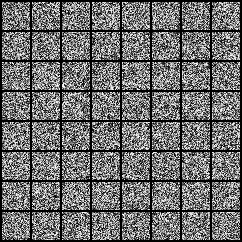

In [ ]:
# ================================================================
# Create Diffusion Animation (GIF) of Sampling Steps
# ================================================================
import imageio

# Prepare the initial noise
model.eval()
num_frames = 50  # Number of frames in GIF (you can increase if you want)
save_every = config['diffusion']['num_timesteps'] // num_frames

samples = torch.randn((config['train']['num_samples'], config['dataset']['im_channels'],
                       config['dataset']['im_size'], config['dataset']['im_size']), device=device)
frames = []

with torch.no_grad():
    for i in reversed(range(config['diffusion']['num_timesteps'])):
        t = torch.full((samples.shape[0],), i, device=device, dtype=torch.long)
        noise_pred = model(samples, t)
        samples = sched.sample_prev(samples, noise_pred, t)

        # Save every N steps
        if i % save_every == 0 or i == 0:
            samples_show = (samples + 1) * 0.5
            grid = make_grid(samples_show, nrow=8)
            grid_np = grid.mul(255).permute(1, 2, 0).byte().cpu().numpy()
            frames.append(grid_np)

# Save the frames as an animated GIF
gif_path = "/kaggle/working/diffusion_steps.gif"
imageio.mimsave(gif_path, frames, fps=5)

print(f"Animation saved to {gif_path}")

# Display GIF inside notebook
from IPython.display import Image
Image(filename=gif_path)


Using: cuda
Files already downloaded and verified


Epoch 1: 100%|██████████| 1563/1563 [03:02<00:00,  8.57it/s]


Epoch 1: Loss 0.1036


Epoch 2: 100%|██████████| 1563/1563 [02:59<00:00,  8.69it/s]


Epoch 2: Loss 0.0446


Epoch 3: 100%|██████████| 1563/1563 [02:58<00:00,  8.76it/s]


Epoch 3: Loss 0.0393


Epoch 4: 100%|██████████| 1563/1563 [02:58<00:00,  8.74it/s]


Epoch 4: Loss 0.0371


Epoch 5: 100%|██████████| 1563/1563 [02:59<00:00,  8.73it/s]


Epoch 5: Loss 0.0366


Epoch 6: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 6: Loss 0.0355


Epoch 7: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 7: Loss 0.0351


Epoch 8: 100%|██████████| 1563/1563 [02:58<00:00,  8.74it/s]


Epoch 8: Loss 0.0345


Epoch 9: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 9: Loss 0.0338


Epoch 10: 100%|██████████| 1563/1563 [02:58<00:00,  8.74it/s]


Epoch 10: Loss 0.0341


Epoch 11: 100%|██████████| 1563/1563 [02:58<00:00,  8.74it/s]


Epoch 11: Loss 0.0334


Epoch 12: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 12: Loss 0.0334


Epoch 13: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 13: Loss 0.0334


Epoch 14: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 14: Loss 0.0332


Epoch 15: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 15: Loss 0.0328


Epoch 16: 100%|██████████| 1563/1563 [02:58<00:00,  8.74it/s]


Epoch 16: Loss 0.0328


Epoch 17: 100%|██████████| 1563/1563 [02:58<00:00,  8.75it/s]


Epoch 17: Loss 0.0330


Epoch 18: 100%|██████████| 1563/1563 [02:58<00:00,  8.76it/s]


Epoch 18: Loss 0.0329


Epoch 19: 100%|██████████| 1563/1563 [02:59<00:00,  8.71it/s]


Epoch 19: Loss 0.0325


Epoch 20: 100%|██████████| 1563/1563 [03:00<00:00,  8.68it/s]


Epoch 20: Loss 0.0326


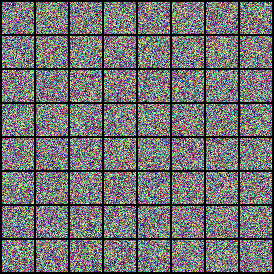

In [ ]:
# DDPM-PyTorch for CIFAR-10


import os, math, yaml, torch, imageio
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

# === CONFIG ===
config = {
    'dataset': {
        'im_size': 32,
        'im_channels': 3
    },
    'diffusion': {
        'num_timesteps': 1000,
        'beta_start': 0.0001,
        'beta_end': 0.02
    },
    'model': {
        'down_channels': [32, 64, 128, 256],
        'mid_channels': [256, 256, 128],
        'down_sample': [True, True, False],
        'time_emb_dim': 256,
        'num_heads': 4,
        'num_down_layers': 2,
        'num_mid_layers': 2,
        'num_up_layers': 2
    },
    'train': {
        'batch_size': 32,
        'epochs': 20,
        'lr': 1e-4,
        'num_samples': 64,
        'save_path': '/kaggle/working/ddpm_cifar_ckpt.pth'
    }
}

# === Dataset ===
transform = transforms.Compose([
    transforms.Resize(config['dataset']['im_size']),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])
dataset = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=config['train']['batch_size'], shuffle=True)

# === Scheduler ===
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def add_noise(self, x0, noise, t):
        a = self.sqrt_alpha_cumprod.to(x0.device)[t].view(-1,1,1,1)
        b = self.sqrt_one_minus_alpha_cumprod.to(x0.device)[t].view(-1,1,1,1)
        return a * x0 + b * noise

    def sample_prev(self, xt, noise_pred, t):
        beta = self.betas.to(xt.device)[t].view(-1,1,1,1)
        sqrt_alpha = torch.sqrt(1. - beta)
        sqrt_1m_cum = self.sqrt_one_minus_alpha_cumprod.to(xt.device)[t].view(-1,1,1,1)
        mean = (xt - beta * noise_pred / sqrt_1m_cum) / sqrt_alpha
        if (t == 0).all(): return mean
        return mean + torch.sqrt(beta) * torch.randn_like(xt)

# === Time Embedding ===
def get_time_embedding(t, dim):
    half = dim // 2
    emb = math.log(10000) / (half - 1)
    emb = torch.exp(torch.arange(half, device=t.device) * -emb)
    emb = t[:, None] * emb[None, :]
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

# === Model Blocks ===
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_c)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.t_proj = nn.Linear(t_dim, out_c)
        self.norm2 = nn.GroupNorm(8, out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.skip = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()
    def forward(self, x, t):
        h = F.silu(self.norm1(x))
        h = self.conv1(h) + self.t_proj(t)[:, :, None, None]
        h = F.silu(self.norm2(h))
        return self.conv2(h) + self.skip(x)

class AttentionBlock(nn.Module):
    def __init__(self, c, heads):
        super().__init__()
        self.norm = nn.GroupNorm(8, c)
        self.attn = nn.MultiheadAttention(c, heads, batch_first=True)
    def forward(self, x):
        B,C,H,W = x.shape
        x_ = self.norm(x).view(B,C,H*W).permute(0,2,1)
        x_,_ = self.attn(x_, x_, x_)
        return x + x_.permute(0,2,1).view(B,C,H,W)

class DownBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim, down, n, heads):
        super().__init__()
        self.blocks = nn.ModuleList([ResBlock(in_c if i==0 else out_c, out_c, t_dim) for i in range(n)])
        self.attn = AttentionBlock(out_c, heads)
        self.down = nn.Conv2d(out_c, out_c, 4, 2, 1) if down else nn.Identity()
    def forward(self, x, t):
        for b in self.blocks: x = b(x, t)
        return self.down(self.attn(x))

class MidBlock(nn.Module):
    def __init__(self, in_c, out_c, t_dim, n, heads):
        super().__init__()
        self.blocks = nn.ModuleList([ResBlock(in_c if i==0 else out_c, out_c, t_dim) for i in range(n+1)])
        self.attn = AttentionBlock(out_c, heads)
    def forward(self, x, t):
        for b in self.blocks: x = self.attn(b(x, t))
        return x

class UpBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c, t_dim, up, n, heads):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, in_c, 4, 2, 1) if up else nn.Identity()
        self.blocks = nn.ModuleList([ResBlock(in_c+skip_c if i==0 else out_c, out_c, t_dim) for i in range(n)])
        self.attn = AttentionBlock(out_c, heads)
    def forward(self, x, skip, t):
        x = torch.cat([self.up(x), skip], dim=1)
        for b in self.blocks: x = b(x, t)
        return self.attn(x)

class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.init = nn.Conv2d(3, cfg['down_channels'][0], 3, padding=1)
        self.t_proj = nn.Sequential(
            nn.Linear(cfg['time_emb_dim'], cfg['time_emb_dim']),
            nn.SiLU(),
            nn.Linear(cfg['time_emb_dim'], cfg['time_emb_dim'])
        )
        self.downs = nn.ModuleList([
            DownBlock(cfg['down_channels'][i], cfg['down_channels'][i+1], cfg['time_emb_dim'],
                      cfg['down_sample'][i], cfg['num_down_layers'], cfg['num_heads'])
            for i in range(len(cfg['down_sample']))
        ])
        self.mid = MidBlock(cfg['mid_channels'][0], cfg['mid_channels'][1], cfg['time_emb_dim'],
                            cfg['num_mid_layers'], cfg['num_heads'])
        self.ups = nn.ModuleList([
            UpBlock(cfg['down_channels'][i+1], cfg['down_channels'][i], cfg['down_channels'][i],
                    cfg['time_emb_dim'], cfg['down_sample'][i], cfg['num_up_layers'], cfg['num_heads'])
            for i in reversed(range(len(cfg['down_sample'])))
        ])
        self.out_norm = nn.GroupNorm(8, cfg['down_channels'][0])
        self.out_conv = nn.Conv2d(cfg['down_channels'][0], 3, 3, padding=1)
    def forward(self, x, t):
        t_emb = self.t_proj(get_time_embedding(t, config['model']['time_emb_dim']))
        skips, x = [], self.init(x)
        for down in self.downs: skips.append(x); x = down(x, t_emb)
        x = self.mid(x, t_emb)
        for up in self.ups: x = up(x, skips.pop(), t_emb)
        return self.out_conv(F.silu(self.out_norm(x)))

# === Training ===
model = UNet(config['model']).to(device)
opt = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
sched = LinearNoiseScheduler(**config['diffusion'])
loss_fn = nn.MSELoss()

for epoch in range(config['train']['epochs']):
    model.train()
    total = 0
    for imgs, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        t = torch.randint(0, config['diffusion']['num_timesteps'], (imgs.size(0),), device=device)
        noise = torch.randn_like(imgs)
        noisy = sched.add_noise(imgs, noise, t)
        pred = model(noisy, t)
        loss = loss_fn(pred, noise)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    print(f"Epoch {epoch+1}: Loss {total / len(loader):.4f}")

torch.save(model.state_dict(), config['train']['save_path'])

# === Sampling & GIF ===
model.eval()
samples = torch.randn((config['train']['num_samples'], 3, 32, 32), device=device)
frames = []
with torch.no_grad():
    for i in reversed(range(config['diffusion']['num_timesteps'])):
        t = torch.full((samples.shape[0],), i, device=device)
        samples = sched.sample_prev(samples, model(samples, t), t)
        if i % 40 == 0 or i == 0:
            grid = make_grid((samples + 1) / 2, nrow=8).permute(1,2,0).cpu().numpy()
            frames.append((grid * 255).astype('uint8'))

gif_path = "/kaggle/working/cifar10_diffusion.gif"
imageio.mimsave(gif_path, frames, fps=5)
Image(filename=gif_path)